In [4]:
%matplotlib inline

In [523]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
import numpy as np
from random import randrange
from datetime import timedelta
from scipy.stats import shapiro

## Data cleaning
We'll remove rows with negative values and nan values. This unfortunately takes out a ton of data and I think I should try to remove cells rather than rows.

In [408]:
rg_data = pd.read_csv("data/moistureVStime.csv")
rg_data['Date'] = pd.to_datetime(rg_data['Date'], infer_datetime_format=True).copy()
rg_data = rg_data.fillna(0)
rg_nums = rg_data[rg_data.columns[4:]]
rg_nums[rg_nums <0] = 0
rg_nums['Date'] = rg_data['Date'][rg_nums.index]
rg_nums = rg_nums.drop_duplicates(subset=None, keep='first', inplace=False)

/Users/andyflury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/andyflury/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/Users/andyflury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

## Grabbing a random date
See stack overflow post. This function currently grabs a random date*time*, so that means we start slicing the dataframe in the middle of a random time and go for 24 hours. This might be better than slicing each day at midnight, I'm not sure.

In [285]:
START_DATE = rg_data['Date'][0]
END_DATE = rg_data['Date'][len(rg_data['Date'])-1]

In [15]:
### https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [149]:
rand_date1 = random_date(START_DATE, END_DATE)
rand_date2 = random_date(START_DATE, END_DATE)
day1 = rg_nums[(rg_nums['Date'] > rand_date1) & (rg_nums['Date'] < rand_date1+datetime.timedelta(days=.5))]
day2 = rg_nums[(rg_nums['Date'] > rand_date2) & (rg_nums['Date'] < rand_date2+datetime.timedelta(days=.5))]

## Drawing Histograms
Pass in a treatment or single raingarden name. The function will plot all treatments it can find as histograms on a single plot. If a name is passed that doesn't match any columns in the df, we give our best guess.

In [151]:
"""
params:
    name: a string like "AI", "AO", "CI-101"
    day_df: a df of soil moisture data sliced for a random 24 hours
    num_bins: the number of bins to plot the histogram with
"""

def treatment_hist(name, day_df, num_bins=8):
    found=False
    for c in rg_data.columns:
        if name in c:
            found=True
            n, bins, patches = plt.hist(day_df[c], num_bins, alpha=0.5, label=c[0:6])
    if not found:
        print("Couldn't find a column with that name. Maybe try:")
        print([col for col in rg_data.columns if name[0:2] in col])
    plt.legend()
    date=day_df['Date'].iloc[0]
    plt.title(str(date.month)+'-'+str(date.day)+'-'+str(date.year))
    plt.show()

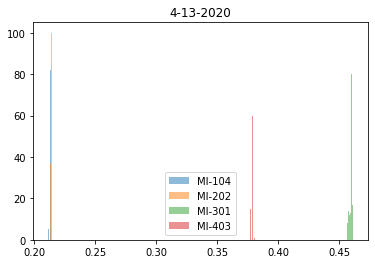

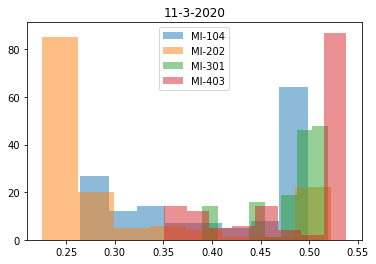

In [152]:
treatment_hist("MI", day1)
treatment_hist("MI", day2)

## Histograms over time
To get a better sense of the distribution of soil moisture with a time dimension, I tried to animate the histograms of each over the past year. It's a little bit clumsy, and built off of [this model](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation).

In [521]:
"""
Create patch for first histogram. Unfortunately couldn't stick this in the loop.
  @param data: rg_nums filtered by treatment or rg  
  @start_date: the first day of data
  @num_bins: the number of bins to build the histogram off of
  @xbounds: the bounds of the histogram

"""
def first_hist(data, start_date, num_bins, xbounds):
    num_bins=60
    xbounds=(0, .6)
    end_date = START_DATE + timedelta(days=1)
    first_day = data[(data['Date'] > START_DATE) & (data['Date'] < end_date)]
    first_day = first_day.drop('Date', axis=1)
    first_day = first_day.stack()
    n, bins = np.histogram(first_day, num_bins, range=xbounds)
    left = bins[:-1]
    right = bins[1:]
    bottom = np.zeros(len(left))
    top = bottom + n
    nrects = len(left)

    nverts = nrects * (1 + 3 + 1)
    verts = np.zeros((nverts, 2))
    codes = np.full(nverts, path.Path.LINETO)
    codes[0::5] = path.Path.MOVETO
    codes[4::5] = path.Path.CLOSEPOLY
    verts[0::5, 0] = left
    verts[0::5, 1] = bottom
    verts[1::5, 0] = left
    verts[1::5, 1] = top
    verts[2::5, 0] = right
    verts[2::5, 1] = top
    verts[3::5, 0] = right
    verts[3::5, 1] = bottom
    return verts, codes

"""
Main function to build the histogram widget.
  @param data: rg_nums or the df of cleaned data (Pandas df)
  @param treatment: the two character name identifying the treatment (string)
  @param rg: the 3 character name identifying the raingarden (string)
        -if null, we use all 4 rgs in the treatment
  @param bins: the number of bins to build the histogram with (int)
  @param xbounds: the min and max values of our x-axis (tuple of floats)
  
"""
def animate_hist(data = rg_nums, treatment="NI", rg=None, bins=60, xbounds=(0, .06)):
    
    ### Create iterable for frames argument
    START_DATE = data['Date'].iloc[0]
    END_DATE = data['Date'][len(data['Date'])-1] - timedelta(days=350)
    day_iterable = range((END_DATE - START_DATE).days)
    
    ### Slice up df ###
    cols_to_keep = [col for col in data.columns if treatment in col]
    if len(cols_to_keep) == 0:
        print("Couldn't find a column with that name. Maybe try:")
        print(set([col[0:2] for col in data.columns[:-1]]))
        return
    if not rg is None: 
        cols_to_keep = [col for col in cols_to_keep if rg in col]
    if len(cols_to_keep) == 0:
        print("Couldn't find a raingarden with that name. Maybe try:")
        print(set(col[3:6] for col in data.columns if treatment in col))
        return
    cols_to_keep.append('Date')
    data = data[cols_to_keep]
    ## Update function ##
    def animate(i):
        nonlocal ann
        start = START_DATE + timedelta(days=i)
        end = start + timedelta(days=1)
        day_data = data[(data['Date'] > start) & (data['Date'] < end)]
        day_data = day_data.drop('Date', 1)
        day_data = day_data.stack()
        n, bins = np.histogram(day_data, 60, range=(0, .9))
        top = bottom + n
        verts[1::5, 1] = top
        verts[2::5, 1] = top
        m, d, y  = start.strftime('%b'), str(start.day), str(start.year)
        ann.remove()
        if day_data.shape[0] // 300 == 0:
            ann = plt.annotate(m+' '+d+' '+y, xy=(.48, 280))
        else:
            ann = plt.annotate(m+' '+d+' '+y, xy=(.48, 1000))
        return [patch, ]
    
    ## First histogram ##
    verts, codes = first_hist(data, START_DATE, bins, xbounds)
    
    ann = plt.annotate(0, xy=(0,0))
    patch = None
    fig, ax = plt.subplots()
    barpath = path.Path(verts, codes)
    patch = patches.PathPatch(
        barpath, facecolor='blue', edgecolor='black', alpha=.5)
    ax.add_patch(patch)
    
    ax.set_xlim(0, .6)
    if rg is None:
        ax.set_ylim(0, 1180)
    else:
        ax.set_ylim(0, 300)
    ax.set_ylabel("Occurence")
    ax.set_xlabel("Soil Moisture")
    if not rg is None:
        ax.set_title("Daily Soil Moisture Dist." + ' ' + treatment + '-' + rg)
    else:
        ax.set_title("Daily Soil Moisture Dist." + ' ' + treatment)
    ani = animation.FuncAnimation(fig, animate, frames=day_iterable, repeat=False, interval=100, blit=True)
    return ani

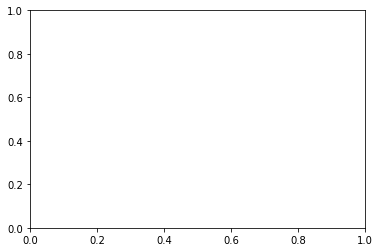

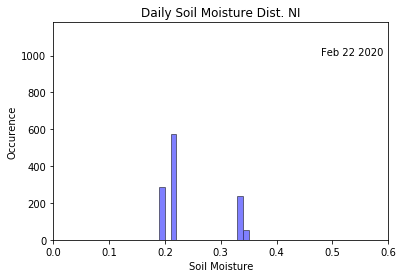

In [522]:
ani = animate_hist(treatment="NI")
HTML(ani.to_jshtml())

## Shapiro Wilk

In [ ]:
shapiro()

In [539]:
def graph_shapiro(data = rg_nums, treatment="NI", rg=None):
    cols_to_keep = [col for col in data.columns if treatment in col]
    if len(cols_to_keep) == 0:
        print("Couldn't find a column with that name. Maybe try:")
        print(set([col[0:2] for col in data.columns[:-1]]))
        return
    if not rg is None: 
        cols_to_keep = [col for col in cols_to_keep if rg in col]
    if len(cols_to_keep) == 0:
        print("Couldn't find a raingarden with that name. Maybe try:")
        print(set(col[3:6] for col in data.columns if treatment in col))
        return
    cols_to_keep.append('Date')
    data = data[cols_to_keep]
    data['Date']= data['Date'].dt.floor('d').groupby('Date').transform(shap)
    print(data)
    return shapiro(data)

In [540]:
graph_shapiro()

0        2020-01-27
1        2020-01-27
2        2020-01-27
3        2020-01-27
4        2020-01-27
            ...    
115601   2021-02-25
115602   2021-02-25
115603   2021-02-25
115604   2021-02-25
115605   2021-02-26
Name: Date, Length: 110294, dtype: datetime64[ns]
(110294, 5)


TypeError: '<' not supported between instances of 'Timestamp' and 'float'